In [1]:
%matplotlib inline

import osmnx as ox
import numpy as np
# from hmmlearn.hmm import MultinomialHMM
import matplotlib.pyplot as plt

# LOAD DATA

In [2]:
import pandas as pd
# lat | lon,
# ...
fname='preprocess025.csv'
path='data/'
df = pd.read_csv(f'{path}{fname}')
df = df.loc[:,['vehicle','x','y','datetime','trip','heading']]
df

,vehicle,x,y,datetime,trip,heading
0,36A26255,106.669520,10.772121,4/27/2018 9:22,0,150.921623
1,36A26255,106.669930,10.771392,4/27/2018 9:22,0,161.372021
2,36A26255,106.669975,10.771260,4/27/2018 9:22,0,164.387732
3,36A26255,106.670170,10.770570,4/27/2018 9:22,0,153.277055
4,36A26255,106.670420,10.770079,4/27/2018 9:23,0,153.277055
...,...,...,...,...,...,...
11870,93A07902,106.669460,10.767908,4/27/2018 15:49,2248,90.799120
11871,93A07902,106.666640,10.768773,4/27/2018 16:46,2249,110.174557
11872,93A07902,106.669120,10.767872,4/27/2018 16:46,2249,95.529607
11873,93A07902,106.670290,10.767760,4/27/2018 16:47,2249,93.112788


# TEST: Hidden Markov Models by Kuanbutts
http://kuanbutts.com/2020/08/25/simplified-map-matching/

## Get osm graph: vbd

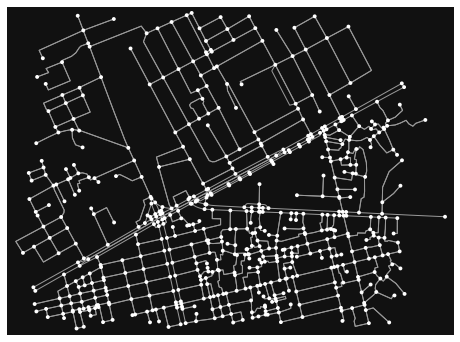

In [4]:
min_x = df['x'].min()
max_x = df['x'].max()

min_y = df['y'].min()
max_y = df['y'].max()
west, south, east, north = max_x, min_y, min_x, max_y
G1 = ox.graph_from_bbox(north, south, east, west,network_type='all_private', truncate_by_edge=True)
fig, ax = ox.plot_graph(G1)


## Get osm graph: article

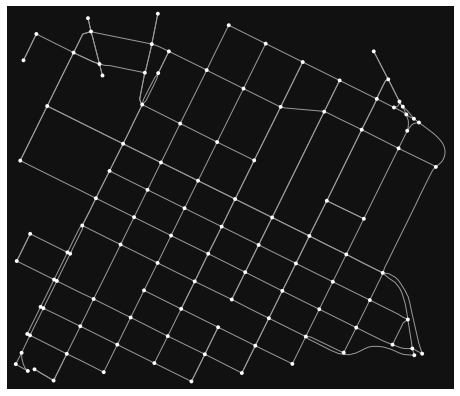

In [53]:
from shapely.geometry import Polygon

p = Polygon([
            [
              -122.27465629577637,
              37.7983230783235
            ],
            [
              -122.26096630096434,
              37.7983230783235
            ],
            [
              -122.26096630096434,
              37.80761398306056
            ],
            [
              -122.27465629577637,
              37.80761398306056
            ],
            [
              -122.27465629577637,
              37.7983230783235
            ]
          ])

west, south, east, north = p.bounds
G1 = ox.graph_from_bbox(north, south, east, west,network_type='drive')
fig, ax = ox.plot_graph(G1)

## Convert graph to GDF

In [5]:
import geopandas as gpd
from shapely.geometry import LineString

rows = []
for node_from, node_to, edge in G1.edges(data=True):
    if "geometry" in edge.keys():
        geometry = edge["geometry"]
    else:
        f = G1.nodes[node_from]
        t = G1.nodes[node_to]
        geometry = LineString([[f["x"], f["y"]], [t["x"], t["y"]]])
    base = {
        "from": node_from,
        "to": node_to,
        "id": edge["osmid"],
        "length": edge["length"],  # meters
        "geometry": geometry,
    }
    rows.append(base)
gdf = gpd.GeoDataFrame(rows)

In [6]:
gdf.head()

,from,to,id,length,geometry
0,366372448,5057828486,32586227,30.882,"LINESTRING (106.67178 10.76668, 106.67169 10.7..."
1,366372448,5057828564,32586227,38.903,"LINESTRING (106.67178 10.76668, 106.67184 10.7..."
2,366372448,5057828560,468380366,28.809,"LINESTRING (106.67178 10.76668, 106.67176 10.7..."
3,366372448,5057828543,468380366,40.051,"LINESTRING (106.67178 10.76668, 106.67180 10.7..."
4,366374108,5057828212,32586228,19.541,"LINESTRING (106.66511 10.76511, 106.66528 10.7..."


## Init a observation trace: vbd

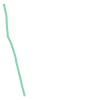

In [9]:
trace = df[df.trip==1][['x','y']]

trace = trace.apply(lambda coord: list([coord.x, coord.y]), axis=1)
trace = LineString(list(trace))
trace

## Init a observation trace: article

In [115]:
# trace = LineString([[-122.26694762706754,37.79925985116652],[-122.26666867732999,37.79970068133491],[-122.2660920023918,37.800605646561564],[-122.26770132780074,37.80126899810456],[-122.26859986782071,37.80141311202907],[-122.26758331060408,37.80292417198254],[-122.26653456687926,37.804909907830265],[-122.26547777652739,37.806312818153785],[-122.26666331291199,37.80684261119228],[-122.26750552654266,37.80545242616099],[-122.26820826530457,37.80428685451822],[-122.27041840553284,37.80534222744762],[-122.27078318595886,37.80484209275872],[-122.27197408676149,37.8028076116559],[-122.27447390556335,37.80395201417224]])
trace = LineString([[-122.27041840553284,37.80534222744762],[-122.27078318595886,37.80484209275872],[-122.27197408676149,37.8028076116559],[-122.27447390556335,37.80395201417224]])

## Plot

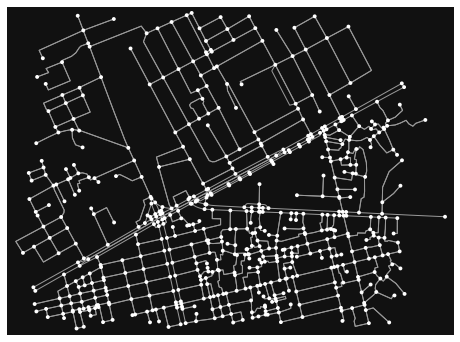

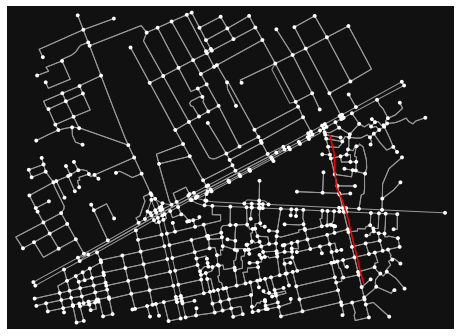

<Figure size 432x288 with 0 Axes>

In [10]:
fig, ax = ox.plot_graph(G1)
gpd.GeoSeries([trace]).plot(ax=ax, color='red')
fig

## Helper methods

In [11]:
from math import cos, sin, asin, sqrt, radians

def haversine(lat1, lon1, lat2, lon2):
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km * 1000

In [12]:
from shapely.geometry import Point

def get_edges(gdf, x, y, t=50):
    p = Point(x, y)
    
    near_edges = []
    for gdf_ix, row in gdf.iterrows():
        l = row["geometry"]
        p2 = l.interpolate(l.project(p))
        d = haversine(y, x, p2.y, p2.x)
        if d < t:
            near_edges.append({
                "id": gdf_ix,
                "distance": d,
                "from_node": row["from"],
                "to_node": row["to"],
            })
    return near_edges

## HMM

In [13]:
class StateNode():
    def __init__(self, trace_id, edge_id, distance, from_node, to_node, terminal=None):
        self.trace_id = trace_id
        self.edge_id = edge_id
        self.distance = distance
        self.from_node = from_node
        self.to_node = to_node
        self.terminal = terminal

In [14]:
import networkx as nx
import geopandas as gpd
# initialize state graph
markov_chain = nx.DiGraph()

# initialize a start state with no real trace/edge associated
start_state_node = StateNode(None, None, None, None, None, "start")
markov_chain.add_node(start_state_node)

# initialize state layers to connect each
last_state = [start_state_node]

for trace_ix, xy in enumerate(trace.coords):
    current_state = []
    x, y = xy

    # Step 1: For each trace point get a list of edges
    edges = get_edges(gdf, x, y)

    # Step 2: Create adjacency list: each edge can tragnsition to every other edge
    for e in edges:
        next_state_node = StateNode(trace_ix, e["id"], e["distance"], e["from_node"], e["to_node"])
        
        markov_chain.add_node(next_state_node)
        current_state.append(next_state_node)
        
        for last_node in last_state:
            markov_chain.add_edge(last_node, next_state_node)
    
    # reset what last state is
    last_state = current_state
    
# add last state node placeholder
end_state_node = StateNode(None, None, None, None, None, "end")
markov_chain.add_node(end_state_node)
for last_node in last_state:
    markov_chain.add_edge(last_node, end_state_node)

In [15]:
def get_edge_likelihood(start_node, end_node, attributes):
    # base conditions for terminal nodes
    if start_node.terminal == "start" or end_node.terminal == "end":
	# don't worry about first placeholder node to first "real" state node
	# and same for final placeholder terminal node
        return 1

    # calculate emission weight (likelihood of point being on this line)
    emission_weight = start_node.distance ** 2  # simplified to exponentially weight greater distances

    # calculate transition weight (likelihood of going from one edge to the next)
    try:
        graph_path = nx.dijkstra_path(G1, start_node.to_node, end_node.from_node, weight="length")
        lengths = []
        for eid_from, eid_to in zip(graph_path[:-1], graph_path[1:]):
            lengths.append(G1[eid_from][eid_to][0]["length"])
        distance = sum(lengths)
    except nx.NetworkXNoPath:
        # fallback for impossible paths
        distance = 1_000_000
    
    transition_weight = distance ** 2  # simplified to exponentially weight greater distances

    # simplified example of combining the two factors
    return emission_weight + transition_weight

In [16]:
calculated_path = nx.dijkstra_path(markov_chain, start_state_node, end_state_node, weight=get_edge_likelihood)


## Plot traces

<AxesSubplot:>

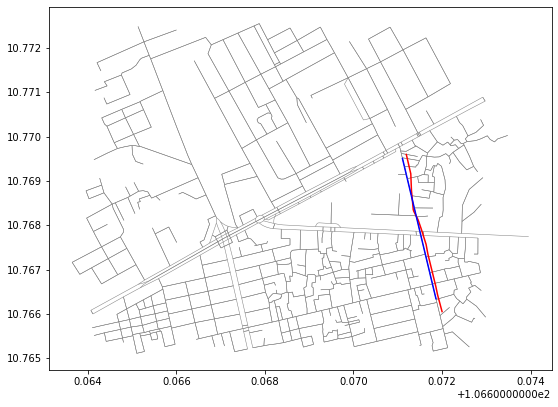

In [17]:
# plot the base map in grey
ax = gdf.plot(figsize=(9,9), lw=0.5, color="grey")

# raw trace in red
gpd.GeoSeries([trace]).plot(ax=ax, color="red")

# map-matched trace in blue
calculated_path_trimmed = [c for c in calculated_path if c.edge_id is not None]

path_edges = []
for cp in calculated_path_trimmed:
    row = gdf.loc[cp.edge_id]

    if len(path_edges) == 0:
        path_edges.append(row)
        continue
    
    last_edge = path_edges[-1]
    if last_edge.to == row["from"]:
        path_edges.append(row)
        continue
    
    intermediate_path = nx.dijkstra_path(G1, last_edge.to, row["from"], weight="length")
    for ip_id_from, ip_id_to in zip(intermediate_path[:-1], intermediate_path[1:]):
        mask_1 = gdf["from"] == ip_id_from
        mask_2 = gdf["to"] == ip_id_to
        ip_row = gdf[mask_1 & mask_2].head(1).squeeze()
        path_edges.append(ip_row)


gpd.GeoSeries([row["geometry"] for row in path_edges]).plot(ax=ax, color="blue")